In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import matplotlib.cm as cm
from scipy.spatial.distance import cdist

% matplotlib inline

In [2]:
air_reserve=pd.read_csv('../../data2/air_reserve.csv')
air_store=pd.read_csv('../../data2/air_store_info.csv')
air_visit=pd.read_csv('../../data2/air_visit_data.csv')
dates=pd.read_csv('../../data2/date_info.csv')
hpg_reserve=pd.read_csv('../../data2/hpg_reserve.csv')
hpg_store=pd.read_csv('../../data2/hpg_store_info.csv')
sample_sub=pd.read_csv('../../data2/sample_submission.csv')
store_relation=pd.read_csv('../../data2/store_id_relation.csv')

In [3]:
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null object
reserve_datetime    92378 non-null object
reserve_visitors    92378 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


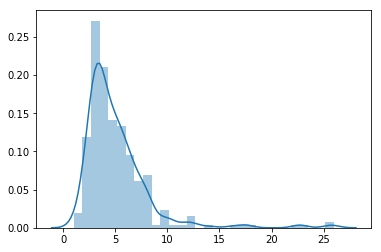

In [4]:
sns.distplot(air_reserve.groupby('air_store_id').agg('mean'))

In [5]:
air_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [6]:
air_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null object
visitors        252108 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [7]:
"""
Contributions from:
DSEverything - Mean Mix - Math, Geo, Harmonic (LB 0.493) 
https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493
JdPaletto - Surprised Yet? - Part2 - (LB: 0.503)
https://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503
hklee - weighted mean comparisons, LB 0.497, 1ST
https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st

Also all comments for changes, encouragement, and forked scripts rock

Keep the Surprise Going
"""

import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor

from keras.layers import Embedding, Input, Dense
from keras.models import Model
import keras
import keras.backend as K

import matplotlib.pyplot as plt

/home/kaih/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kaih/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/kaih/.local/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationW

In [8]:

#"START HKLEE FEATURE"
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('../../data2/*.csv')}
for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(lambda x: (x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1, axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) 

sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=['air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), how='left')['visitors_y'].values

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), on='air_store_id', how='left')['visitors_y'].values

test_visit_var = sample_submission.visitors.map(pd.np.expm1)

data = {
    'tra': pd.read_csv('../../data2/air_visit_data.csv')
    }

data['tra'] = data['tra'].merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
data['tra'] = data['tra'].merge(visitors, on=['air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = data['tra'].visitors_y.isnull()
data['tra'].loc[missings, 'visitors_y'] = data['tra'][missings].merge(visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), how='left')['visitors_y'].values

missings = data['tra'].visitors_y.isnull()
data['tra'].loc[missings, 'visitors_y'] = data['tra'][missings].merge(visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), on='air_store_id', how='left')['visitors_y'].values

train_visit_var = data['tra'].visitors_y.map(pd.np.expm1)
#"END HKLEE FEATURE"


In [9]:

data = {
    'tra': pd.read_csv('../../data2/air_visit_data.csv'),
    'as': pd.read_csv('../../data2/air_store_info.csv'),
    'hs': pd.read_csv('../../data2/hpg_store_info.csv'),
    'ar': pd.read_csv('../../data2/air_reserve.csv'),
    'hr': pd.read_csv('../../data2/hpg_reserve.csv'),
    'id': pd.read_csv('../../data2/store_id_relation.csv'),
    'tes': pd.read_csv('../../data2/sample_submission.csv'),
    'hol': pd.read_csv('../../data2/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime']).dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime']).dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
#OPTIMIZED BY JEROME VALLET
tmp = data['tra'].groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations']
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='inner', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

value_col = ['holiday_flg','min_visitors','mean_visitors','median_visitors','max_visitors','count_observations',
'rs1_x','rv1_x','rs2_x','rv2_x','rs1_y','rv1_y','rs2_y','rv2_y','total_reserv_sum','total_reserv_mean',
'total_reserv_dt_diff_mean','date_int','var_max_lat','var_max_long','lon_plus_lat']

nn_col = value_col + ['dow', 'year', 'month', 'air_store_id2', 'air_area_name', 'air_genre_name',
'air_area_name0', 'air_area_name1', 'air_area_name2', 'air_area_name3', 'air_area_name4',
'air_area_name5', 'air_area_name6', 'air_genre_name0', 'air_genre_name1',
'air_genre_name2', 'air_genre_name3', 'air_genre_name4']


X = train.copy()
X_test = test[nn_col].copy()

value_scaler = preprocessing.MinMaxScaler()
for vcol in value_col:
    X[vcol] = value_scaler.fit_transform(X[vcol].values.astype(np.float64).reshape(-1, 1))
    X_test[vcol] = value_scaler.transform(X_test[vcol].values.astype(np.float64).reshape(-1, 1))

X_train = list(X[nn_col].T.as_matrix())
Y_train = np.log1p(X['visitors']).values
nn_train = [X_train, Y_train]
nn_test = [list(X_test[nn_col].T.as_matrix())]
print("Train and test data prepared")


Train and test data prepared


In [10]:
def get_nn_complete_model(train, hidden1_neurons=35, hidden2_neurons=15):
    """
    Input:
        train:           train dataframe(used to define the input size of the embedding layer)
        hidden1_neurons: number of neurons in the first hidden layer
        hidden2_neurons: number of neurons in the first hidden layer
    Output:
        return 'keras neural network model'
    """
    K.clear_session()

    air_store_id = Input(shape=(1,), dtype='int32', name='air_store_id')
    air_store_id_emb = Embedding(len(train['air_store_id2'].unique()) + 1, 15, input_shape=(1,),
                                 name='air_store_id_emb')(air_store_id)
    air_store_id_emb = keras.layers.Flatten(name='air_store_id_emb_flatten')(air_store_id_emb)

    dow = Input(shape=(1,), dtype='int32', name='dow')
    dow_emb = Embedding(8, 3, input_shape=(1,), name='dow_emb')(dow)
    dow_emb = keras.layers.Flatten(name='dow_emb_flatten')(dow_emb)

    month = Input(shape=(1,), dtype='int32', name='month')
    month_emb = Embedding(13, 3, input_shape=(1,), name='month_emb')(month)
    month_emb = keras.layers.Flatten(name='month_emb_flatten')(month_emb)

    air_area_name, air_genre_name = [], []
    air_area_name_emb, air_genre_name_emb = [], []
    for i in range(7):
        area_name_col = 'air_area_name' + str(i)
        air_area_name.append(Input(shape=(1,), dtype='int32', name=area_name_col))
        tmp = Embedding(len(train[area_name_col].unique()), 3, input_shape=(1,),
                        name=area_name_col + '_emb')(air_area_name[-1])
        tmp = keras.layers.Flatten(name=area_name_col + '_emb_flatten')(tmp)
        air_area_name_emb.append(tmp)

        if i > 4:
            continue
        area_genre_col = 'air_genre_name' + str(i)
        air_genre_name.append(Input(shape=(1,), dtype='int32', name=area_genre_col))
        tmp = Embedding(len(train[area_genre_col].unique()), 3, input_shape=(1,),
                        name=area_genre_col + '_emb')(air_genre_name[-1])
        tmp = keras.layers.Flatten(name=area_genre_col + '_emb_flatten')(tmp)
        air_genre_name_emb.append(tmp)

    air_genre_name_emb = keras.layers.concatenate(air_genre_name_emb)
    air_genre_name_emb = Dense(4, activation='sigmoid', name='final_air_genre_emb')(air_genre_name_emb)

    air_area_name_emb = keras.layers.concatenate(air_area_name_emb)
    air_area_name_emb = Dense(4, activation='sigmoid', name='final_air_area_emb')(air_area_name_emb)
    
    air_area_code = Input(shape=(1,), dtype='int32', name='air_area_code')
    air_area_code_emb = Embedding(len(train['air_area_name'].unique()), 8, input_shape=(1,), name='air_area_code_emb')(air_area_code)
    air_area_code_emb = keras.layers.Flatten(name='air_area_code_emb_flatten')(air_area_code_emb)
    
    air_genre_code = Input(shape=(1,), dtype='int32', name='air_genre_code')
    air_genre_code_emb = Embedding(len(train['air_genre_name'].unique()), 5, input_shape=(1,),
                                   name='air_genre_code_emb')(air_genre_code)
    air_genre_code_emb = keras.layers.Flatten(name='air_genre_code_emb_flatten')(air_genre_code_emb)

    
    holiday_flg = Input(shape=(1,), dtype='float32', name='holiday_flg')
    year = Input(shape=(1,), dtype='float32', name='year')
    min_visitors = Input(shape=(1,), dtype='float32', name='min_visitors')
    mean_visitors = Input(shape=(1,), dtype='float32', name='mean_visitors')
    median_visitors = Input(shape=(1,), dtype='float32', name='median_visitors')
    max_visitors = Input(shape=(1,), dtype='float32', name='max_visitors')
    count_observations = Input(shape=(1,), dtype='float32', name='count_observations')
    rs1_x = Input(shape=(1,), dtype='float32', name='rs1_x')
    rv1_x = Input(shape=(1,), dtype='float32', name='rv1_x')
    rs2_x = Input(shape=(1,), dtype='float32', name='rs2_x')
    rv2_x = Input(shape=(1,), dtype='float32', name='rv2_x')
    rs1_y = Input(shape=(1,), dtype='float32', name='rs1_y')
    rv1_y = Input(shape=(1,), dtype='float32', name='rv1_y')
    rs2_y = Input(shape=(1,), dtype='float32', name='rs2_y')
    rv2_y = Input(shape=(1,), dtype='float32', name='rv2_y')
    total_reserv_sum = Input(shape=(1,), dtype='float32', name='total_reserv_sum')
    total_reserv_mean = Input(shape=(1,), dtype='float32', name='total_reserv_mean')
    total_reserv_dt_diff_mean = Input(shape=(1,), dtype='float32', name='total_reserv_dt_diff_mean')
    date_int = Input(shape=(1,), dtype='float32', name='date_int')
    var_max_lat = Input(shape=(1,), dtype='float32', name='var_max_lat')
    var_max_long = Input(shape=(1,), dtype='float32', name='var_max_long')
    lon_plus_lat = Input(shape=(1,), dtype='float32', name='lon_plus_lat')

    date_emb = keras.layers.concatenate([dow_emb, month_emb, year, holiday_flg])
    date_emb = Dense(5, activation='sigmoid', name='date_merged_emb')(date_emb)

    cat_layer = keras.layers.concatenate([holiday_flg, min_visitors, mean_visitors,
                    median_visitors, max_visitors, count_observations, rs1_x, rv1_x,
                    rs2_x, rv2_x, rs1_y, rv1_y, rs2_y, rv2_y,
                    total_reserv_sum, total_reserv_mean, total_reserv_dt_diff_mean,
                    date_int, var_max_lat, var_max_long, lon_plus_lat,
                    date_emb, air_area_name_emb, air_genre_name_emb,
                    air_area_code_emb, air_genre_code_emb, air_store_id_emb])

    m = Dense(hidden1_neurons, name='hidden1',
             kernel_initializer=keras.initializers.RandomNormal(mean=0.0,
                            stddev=0.05, seed=None))(cat_layer)
    m = keras.layers.LeakyReLU(alpha=0.2)(m)
    m = keras.layers.BatchNormalization()(m)
    
    m1 = Dense(hidden2_neurons, name='hidden2')(m)
    m1 = keras.layers.LeakyReLU(alpha=0.2)(m1)
    m = Dense(1, activation='relu')(m1)

    inp_ten = [
        holiday_flg, min_visitors, mean_visitors, median_visitors, max_visitors, count_observations,
        rs1_x, rv1_x, rs2_x, rv2_x, rs1_y, rv1_y, rs2_y, rv2_y, total_reserv_sum, total_reserv_mean,
        total_reserv_dt_diff_mean, date_int, var_max_lat, var_max_long, lon_plus_lat,
        dow, year, month, air_store_id, air_area_code, air_genre_code
    ]
    inp_ten += air_area_name
    inp_ten += air_genre_name
    model = Model(inp_ten, m)
    model.compile(loss='mse', optimizer='rmsprop', metrics=['acc'])

    return model

In [11]:
# model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, 
#                                             subsample=0.8, max_depth =10)
# model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)

# model3 = XGBRegressor(learning_rate=0.2, n_estimators=200, subsample=0.8, colsample_bytree=0.8, max_depth =10)
# model5 = ensemble.RandomForestRegressor(n_estimators=200,max_depth=12,n_jobs=3)

In [12]:

#Bojan Tunguz / Surprise Me 2!
model4 = get_nn_complete_model(train, hidden2_neurons=12)



for i in range(5):
    model4.fit(nn_train[0], nn_train[1], epochs=2, verbose=0, batch_size=512, shuffle=True)
    model4.fit(nn_train[0], nn_train[1], epochs=3, verbose=1, batch_size=256, shuffle=True, validation_split=0.15)
    model4.fit(nn_train[0], nn_train[1], epochs=8, verbose=0, batch_size=256, shuffle=True)
print("Model4 trained")


Train on 212897 samples, validate on 37571 samples
Epoch 1/3
212897/212897 [==============================] - 4s - loss: 0.2697 - acc: 0.0000e+00 - val_loss: 0.2790 - val_acc: 0.0000e+00
Epoch 2/3
212897/212897 [==============================] - 4s - loss: 0.2652 - acc: 0.0000e+00 - val_loss: 0.3043 - val_acc: 0.0000e+00
Epoch 3/3
212897/212897 [==============================] - 4s - loss: 0.2616 - acc: 0.0000e+00 - val_loss: 0.2950 - val_acc: 0.0000e+00
Train on 212897 samples, validate on 37571 samples
Epoch 1/3
212897/212897 [==============================] - 4s - loss: 0.2465 - acc: 0.0000e+00 - val_loss: 0.2675 - val_acc: 0.0000e+00
Epoch 2/3
212897/212897 [==============================] - 4s - loss: 0.2461 - acc: 0.0000e+00 - val_loss: 0.2426 - val_acc: 0.0000e+00
Epoch 3/3
212897/212897 [==============================] - 3s - loss: 0.2460 - acc: 0.0000e+00 - val_loss: 0.2641 - val_acc: 0.0000e+00
Train on 212897 samples, validate on 37571 samples
Epoch 1/3
212897/212897 [======

In [13]:
# model1.fit(train[col], np.log1p(train['visitors'].values))
# model2.fit(train[col], np.log1p(train['visitors'].values))
# model3.fit(train[col], np.log1p(train['visitors'].values))
# model5.fit(train[col], np.log1p(train['visitors'].values))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=3,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [15]:
model1 = pickle.load(open('model1.pk','rb'))
model2 = pickle.load(open('model2.pk','rb'))
model3 = pickle.load(open('model3.pk','rb'))
model5 = pickle.load(open('model5.pk','rb'))

In [14]:
import pickle
# pickle.dump(model1, open( "model1.pk", "wb" ) )
# pickle.dump(model2, open( "model2.pk", "wb" ) )
# pickle.dump(model3, open( "model3.pk", "wb" ) )
# # pickle.dump(model4, open( "model4.pk", "wb" ) )
# pickle.dump(model5, open( "model5.pk", "wb" ) )

In [31]:

# preds1 = model1.predict(train[col])
# preds2 = model2.predict(train[col])
# preds3 = model3.predict(train[col])
# preds5 = model5.predict(train[col])
# preds4 = pd.Series(model4.predict(nn_train[0]).reshape(-1)).clip(0, 6.8).values

# print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))
# print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))
# print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))
# print('RMSE RamdomForestRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds5))
# print('RMSE NeuralNetwork: ', RMSLE(np.log1p(train['visitors'].values), preds4))

preds1 = model1.predict(test[col])
preds2 = model2.predict(test[col])
preds3 = model3.predict(test[col])
preds5 = model5.predict(test[col])
# .clip(0, 6.8) used to avoid random high values that might occur
preds4 = pd.Series(model4.predict(nn_test[0]).reshape(-1)).clip(0, 6.8).values

# test['visitors'] = 0.2*preds1+0.2*preds2+0.3*preds3+0.3*preds4
test['visitors'] = 0.2*preds1
+0.1*preds2
+0.25*preds3
+0.45*preds4
# +0.1*preds5
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
print("Model predictions done.")


Model predictions done.


In [32]:
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('../../data2/*.csv')}

for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(
    (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=[
    'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub2 = sub2.fillna(-1) # for the unfound values

In [33]:
def final_visitors(x, alt=False):
    visitors_x, visitors_y = x['visitors_x'], x['visitors_y']
    if x['visitors_y'] == -1:
        return visitors_x
    else:
        return 0.7*visitors_x + 0.3*visitors_y* 1.1

sub_merge = pd.merge(sub1, sub2, on='id', how='inner')
sub_merge['visitors'] = sub_merge.apply(lambda x: final_visitors(x), axis=1)
print("Done")
sub_merge[['id', 'visitors']].to_csv('submission.csv', index=False)

Done


In [25]:

# test['visitors'] = (
#     model1.predict(test[col]) +
#     model2.predict(test[col]) + 
#                     model3.predict(test[col])
# #     + 
# #                     model4.predict(test[col])
# ) / 3
# # test['visitors'] = (model1.predict(test[col]) + model2.predict(test[col])) / 2
# test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
# sub1 = test[['id','visitors']].copy()
# # del train; del data;

# # from hklee
# # https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st/code
# dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
#     pd.read_csv(fn)for fn in glob.glob('../../data2/*.csv')}

# for k, v in dfs.items(): locals()[k] = v

# wkend_holidays = date_info.apply(
#     (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
# date_info.loc[wkend_holidays, 'holiday_flg'] = 0
# date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

# visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
# visit_data.drop('calendar_date', axis=1, inplace=True)
# visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

# wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
# visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
# visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

# sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
# sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
# sample_submission.drop('visitors', axis=1, inplace=True)
# sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
# sample_submission = sample_submission.merge(visitors, on=[
#     'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

# missings = sample_submission.visitors.isnull()
# sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
#     visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
#     how='left')['visitors_y'].values

# missings = sample_submission.visitors.isnull()
# sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
#     visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
#     on='air_store_id', how='left')['visitors_y'].values

# sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
# sub2 = sample_submission[['id', 'visitors']].copy()
# sub_merge = pd.merge(sub1, sub2, on='id', how='inner')

# sub_merge['visitors'] = (sub_merge['visitors_x'] + sub_merge['visitors_y']* 1.1)/2

# sub_merge[['id', 'visitors']].to_csv('submission.csv', index=False)